# Final Project
## Oscar Engelbrektson
## CS156, Prof. Sterne, Fall 2019

### 1. Problem Definition

For this final project, I set out to predict the outcome of UFC fights, i.e. which fighter is going to win. If it works well enough, I would like to be able to use it to inform betting strategy. The dataset I used was scraped from ufcstats.com, which has a page of summary statistics for every fight that has taken place since the inception of the UFC - 1997 to 2019.

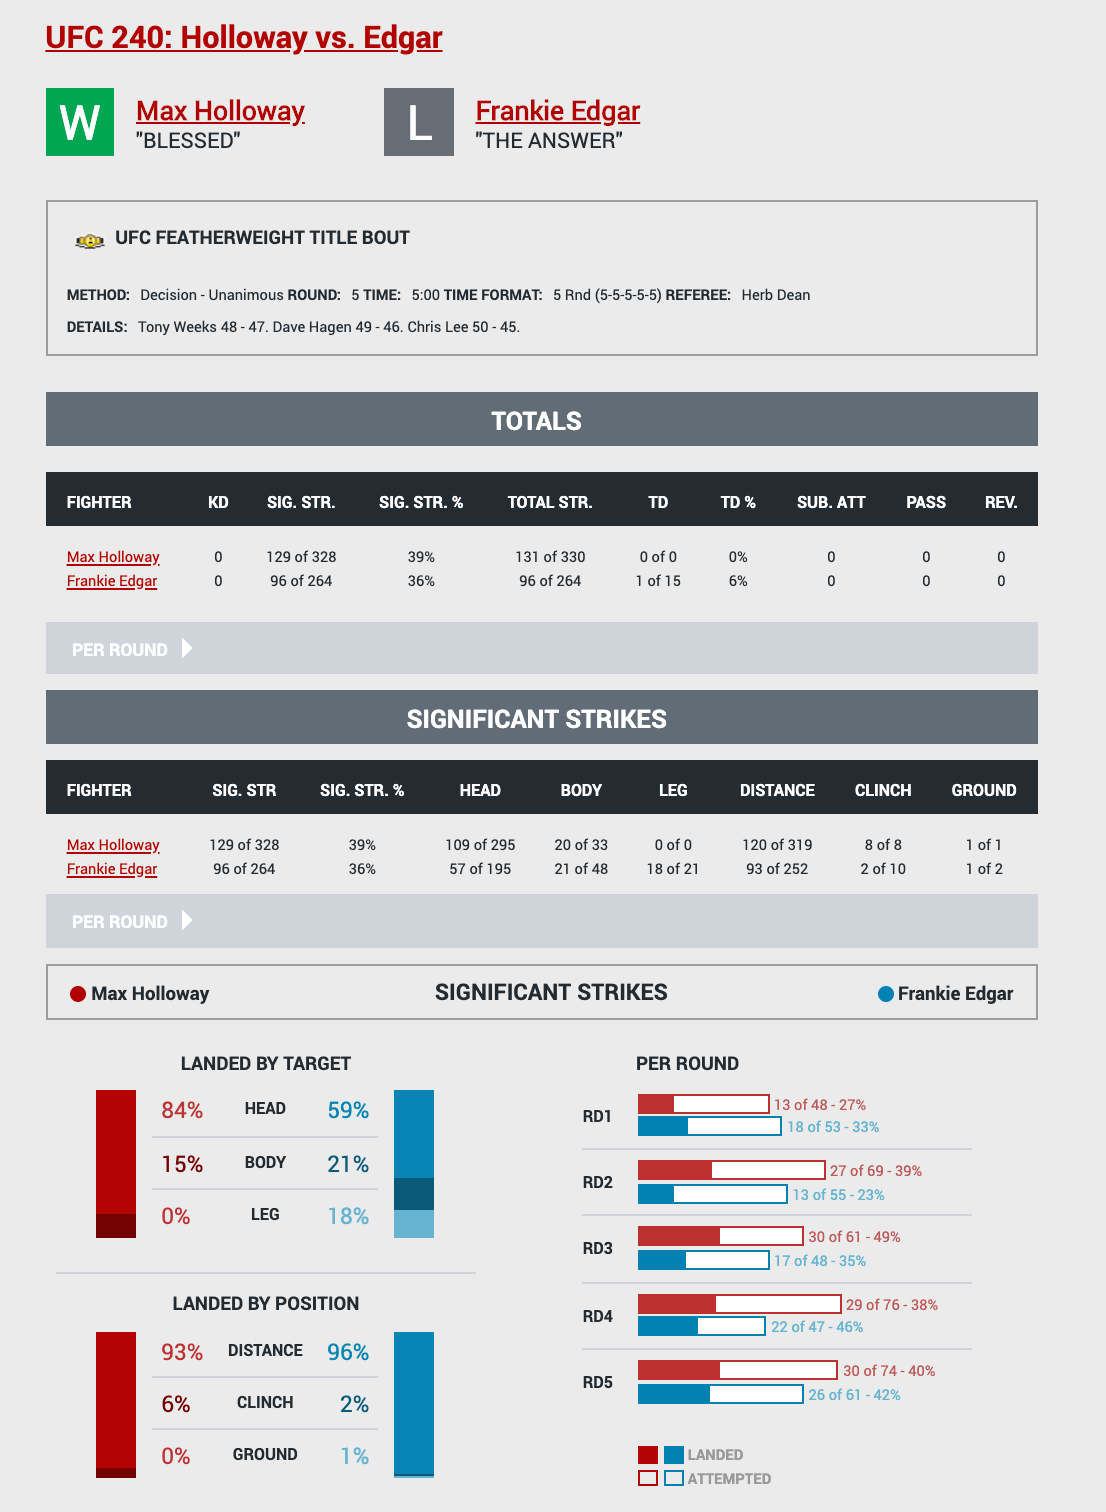

Every row in the dataset represents one such fight, and each statistic presented in this screenshot was included.

### 2. Solution Specification


**Approach**

To solve this prediction problem, we want to make use of all relevant data avaiable for each fighter. We use a filtering, as opposed to a smoothing approach to model training. That is, we use all previous information, but never any more than that. We must not use any observations accrued *during or after* the fight we are trying to predict–no such information will be available in real prediction scenarios, such as UFC245. Concretely, we model p(y_t | y_1:y_t-1, x_1:x_t-1) where y is the outcome, x is a vector of explanatory variables and t = {1,2,..t-1,t,...T} denotes the timestep. 

Going from the scraped data to a dataset of this format required a lot of pre-processing. In general, my approach was to compute the cummulative statistics for each fighter. For example, the average striking accuracy across all
previous fights. 

**Data split**

Observations in this data set are not independendent, as later appearances of a fighter depend on his/her earlier fights. Furthermore, this dependence is not only between different observations of the same fighter. If I know that a fighter is facing the world champion next, that will tell me something about his chances of victory–this is explicitly accounted for in the Trueskill model, and may be implicitly captured by some of the models we fit in the next section. Consequently, it does not make sense to perform ordinary cross-validation to optimise model hyperparameters. Viewed from a different perspective, the objective is to train a model to predict the outcome of future fights given past fights. Consequently, it makes no sense to evaluate the model on its ability to predict fights given past *and future* fights. 

Rather, we perform a temporal train-test split of the data. This has the effect of ensuring that the data on which we evaluate model performance is in the future compared to the training data. We set aside the last 200 fights as a dedicated test set. The remaining data will constitute our trainset. To tune hyperparameters, we will hold out the 600 last fights from the train data, train on the remaining and then evaluate accuracy on the held-out set. We repeat this process 2 more times, with the 400 last held out, then the 200 last held out. The hyperparameter settings that maximise the average accuracy across the 3 held out sets will be chosen. This is likely an established method, but on the offchance that it is not, I would like to call it "K-Hold" cross validation.

The hope is that by varying the held out set on which performance is evaluated, albeit only partially, we can mitigate the some of the overfitting that would likely occur if we only had 1 held out set. This is the approach that most closely mirrors ordinary cross validation, without violating the temporal constraints of this problem.

Once the hyperparameters have been chosen, the model is then trained on all the training data and used to predict the test set outcomes. This result will be the final reported accuracy, used to compare and choose model.


**Evaluation metric**

We are looking to build a model that will predict the probability of a fighter winning a fight before it happens, so as to help us make bets that maximise our expected returns. The payoff of a bet is binary, if you win the bet you get your money back plus profit, but if you lose the bet you loose all the money. With respect the model, the payoff function depends only on whether a prediction was correct or incorrect–it does not distinguish between different types of error and neither should we. As such, prediction accuracy is the metric used to evaluate model performance.

### 3. Testing and Analysis

**Models and results**

The primary model I implemented was the Trueskill model. It was developed by Microsoft to model the skill of players in hopes to make good matches in online game like Halo by matching equally skilled opponents. It is assumed that every player has some time-varying skill, which is unobserved. To objective of the model is to infer the latent player skill from the observed performances–wins, losses and draws. In terms of modelling, skill s for player i at time t, N(s_ti|mu, sigma) represents our belief of the players true skill level. sigma, the uncertainty of our belief decreases as we observe more games of the player. Performance p of player i at time t, in turn is assumed to be a drawn from a normal distribution centered on s_ti with variance beta. The key modelling assumption here is that, whilst the  player skill is specific to each player, the variance of performance around that skill is specific to the game, i.e. the same for all players. I perform cross validation to to set this variance parameter, beta. This model is optimal for this type of match prediction, because it is explicitly made for inferring the skill of players.

The trueskill model only uses the win-loss-draw history of fighters. As I have access to quite detailed data above and beyond that, my idea was to use trueskill win probabilty together with other features as input in a classifier. On the rationale that access to fighter characteristics would complement the trueskill ratings and enable improved prediction accuracy. 

Unfortunately, I was unable to realize this objective. The best performing model I was able to produce was the trueskill model on its own, with test set accuracy of 58.2% (58.5% on training set). Whilst it is unclear what consitutes good prediction performance on this specific problem (due to lack of publically available work), I am confident that this number can be improved further. I firmly believe that there is predictive power contained in the that goes above and beyond that contained only in winning history, I have just not been able to unlock it. I have some more ideas for how to improve in the future (see next section).


My results are summarized below:

| Model | Hyperparameters | Training Accuracy | Test Accuracy | 
| --- | --- | --- | --- | 
| Trueskill | beta=2 | 0.585 | 0.582 | 
| SVM | kernel=RBF, C=1, gamma=0.0001 | 0.560 | 0.478 | 
| SVM, w. Trueskill as feature |kernel=RBF, C=1, gamma=1 | 0.558 | 0.502 | 

Note that performance was markedly worse on the test set as compared to the training set for both the SVMs. The trueskill model, however, maintained . This is expected, as there is no tuning of the parameters of the model per se, it is deterministic given the 

## Ideas for future improvement

Here are some ideas I came up with to late to try out, but would be very interesting to investigate:

1. It is not sufficient to model the offensive output of a fighter, we must also. Looking only at offensive output, a world-class striker like Israel Adesanya, may look mediocre. His power comes from his ability to hit and not get hit–the opponents lacking offensive output is not only indicative of his offensive skill, but also Adesanyas defensive skill. Conversely, other fighters rely on volume to overwhelm, exhaust and ultimately  defeat their opponents. We expect such fighters to get hit more often (making the opponent strike more often that normal), *regardless of the opponent*. Therefore, it is important that we model the defense of fighters also. Concretely, we could interpret every attack attempted but not landed by the opponent to have been successfully defended.

2. What if you ran TrueSkill on strikes: every strike attemt is considered a game between two players; the defender has a defensive skill and the attacker has an offensive skill. Same can be applied to takedowns etc. Naturally, the trueskill rating update rule would have to be modified, to account for the skill level being constant *within* each fight. For example, if there were 100 strikes thrown in a fight, we assume that each one is a performance drawn from the same unobserved striking skill. After having observed each of the 100 strikes, we would have to perform some expectation-maximisation procedure to update our beliefs about the fighters latent striking skill. However, in fighting specifically, there might be some problem with the independence assumption: if you get hit hard in the head, your defensive skill will likely temporarily decrease. Nevertheless, this seems doable and worth exploring. If it works it would have many benefits. Currently, **the largest short-coming of my approach, I believe, is that it does not account for the opposition against which the statistics where recorded.** For example, if you tell me that fighter A landed 4/5 takedowns in his fight against fighter B, my view of his wrestling skill, and ability to score takedowns in future fights, will be vastly different if fighter B is a world-class wrestler as compared to if he was notoriously awful at takedown defence. The trueskill model takes this into account when computing the skill. My idea then would be to compute the striking, wrestling etc offense and defence for every fighter, and use that along with the ordinary trueskill model trained only on the outcome of fights.

**Ramblings of a madman**

As a concluding note, this was a hard project for me. It has taken much longer than I foresaw. I have easily spent more time on this than the other final projects combined and I still don't feel I had enough time. I feel my theoretical approach to the problem is the right one, but I wish I had more time to try out more feature engineering and exploring other models. For example, I was thinking that computing a output/minute statistic and then pairing that with an accuracy statistic might be a promising approach.

Either way, I don't have much in ways of comparison to evaluate what constitutes good accuracy (although I suspect you can get it a lot higher than I was able to). There aren't many other publically available attempts at predicting UFC fights, and the ones that I have been able to find always do something silly (something that seems to me like it invalidated the results). For example, almost everyone I have seen attempt this problem  does a random train-test split–which does not make sense because it turns the prediction task into a smoothing problem, which is different from predicting things in the future given the past–and then gets something like 89% accuracy and calls it a day.

# References:

Data set: 
https://www.kaggle.com/rajeevw/ufcdata#raw_total_fight_data.csv

Trueskill model.
https://trueskill.org/


Bunkera, R. Thabtah, A. (2019). Machine learning framework for sport result prediction. Applied Computing and Informatics.

    Retrieved
    https://www.sciencedirect.com/science/article/pii/S2210832717301485



# 5. Appendices

Below is my jupyter notebook, in which I have done all the work. I have spent more time than I would like to admit trying massage (the approach taking in some of the below cells is more brutish) into the desired format.

## Column definitions:
1. R_ and B_ prefix signifies red and blue corner fighter stats respectively
1. _opp_ containing columns is the average of damage done by the opponent on the fighter
1. KD is number of knockdowns
1. SIG_STR is no. of significant strikes 'landed of attempted'
1. SIG_STR_pct is significant strikes percentage
1. TOTAL_STR is total strikes 'landed of attempted'
1. TD is no. of takedowns
1. TD_pct is takedown percentages
1. SUB_ATT is no. of submission attempts
1. PASS is no. times the guard was passed?
1. REV is the no. of Reversals landed
1. HEAD is no. of significant strinks to the head 'landed of attempted'
1. BODY is no. of significant strikes to the body 'landed of attempted'
1. CLINCH is no. of significant strikes in the clinch 'landed of attempted'
1. GROUND is no. of significant strikes on the ground 'landed of attempted'
1. win_by is method of win
1. last_round is last round of the fight (ex. if it was a KO in 1st, then this will be 1)
1. last_round_time is when the fight ended in the last round
1. Format is the format of the fight (3 rounds, 5 rounds etc.)
1. Referee is the name of the Ref
1. date is the date of the fight
1. location is the location in which the event took place
1. Fight_type is which weight class and whether it's a title bout or not
1. Winner is the winner of the fight
1. Stance is the stance of the fighter (orthodox, southpaw, etc.)
1. Height_cms is the height in centimeter
1. Reach_cms is the reach of the fighter (arm span) in centimeter
1. Weight_lbs is the weight of the fighter in pounds (lbs)
1. age is the age of the fighter
1. title_bout Boolean value of whether it is title fight or not
1. weight_class is which weight class the fight is in (Bantamweight, heavyweight, Women's flyweight, etc.)
1. no_of_rounds is the number of rounds the fight was scheduled for
1. current_lose_streak is the count of current concurrent losses of the fighter
1. current_win_streak is the count of current concurrent wins of the fighter
1. draw is the number of draws in the fighter's ufc career
1. wins is the number of wins in the fighter's ufc career
1. losses is the number of losses in the fighter's ufc career
1. total_rounds_fought is the average of total rounds fought by the fighter
1. total_time_fought(seconds) is the count of total time spent fighting in seconds
1. total_title_bouts is the total number of title bouts taken part in by the fighter
1. win_by_Decision_Majority is the number of wins by majority judges decision in the fighter's ufc career
1. win_by_Decision_Split is the number of wins by split judges decision in the fighter's ufc career
1. win_by_Decision_Unanimous is the number of wins by unanimous judges decision in the fighter's ufc career
1. win_by_KO/TKO is the number of wins by knockout in the fighter's ufc career
1. win_by_Submission is the number of wins by submission in the fighter's ufc career
1. win_by_TKO_Doctor_Stoppage is the number of wins by doctor stoppage in the fighter's ufc career

### Modelling the outcome of fights
"*If you know the enemy and know yourself, you need not fear the result of a hundred battles.*" - Sun Tzu

In [2]:
import pandas as pd
import numpy as np
import pandas_profiling as pp

In [300]:
fight_df = pd.read_csv("/Users/oscarengelbrektson/Downloads/ufcdata/raw_total_fight_data.csv", delimiter=";")

In [301]:
fight_df.loc[fight_df["R_fighter"]=="Israel Adesanya"]

,R_fighter,B_fighter,R_KD,B_KD,R_SIG_STR.,B_SIG_STR.,R_SIG_STR_pct,B_SIG_STR_pct,R_TOTAL_STR.,B_TOTAL_STR.,R_TD,B_TD,R_TD_pct,B_TD_pct,R_SUB_ATT,B_SUB_ATT,R_PASS,B_PASS,R_REV,B_REV,R_HEAD,B_HEAD,R_BODY,B_BODY,R_LEG,B_LEG,R_DISTANCE,B_DISTANCE,R_CLINCH,B_CLINCH,R_GROUND,B_GROUND,win_by,last_round,last_round_time,Format,Referee,date,location,Fight_type,Winner
186,Israel Adesanya,Anderson Silva,0,0,65 of 132,31 of 72,49%,43%,65 of 132,34 of 75,0 of 0,0 of 0,0%,0%,0,0,0,0,0,0,27 of 79,16 of 49,9 of 22,8 of 12,29 of 31,7 of 11,63 of 129,26 of 67,2 of 3,5 of 5,0 of 0,0 of 0,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Herb Dean,"February 09, 2019","Melbourne, Victoria, Australia",Middleweight Bout,Israel Adesanya
573,Israel Adesanya,Marvin Vettori,0,0,57 of 123,46 of 154,46%,29%,67 of 134,60 of 169,0 of 1,2 of 6,0%,33%,0,0,0,1,0,0,31 of 92,20 of 122,11 of 12,7 of 8,15 of 19,19 of 24,57 of 123,44 of 152,0 of 0,2 of 2,0 of 0,0 of 0,Decision - Split,3,5:00,3 Rnd (5-5-5),Herb Dean,"April 14, 2018","Glendale, Arizona, USA",Middleweight Bout,Israel Adesanya


In [302]:
pp.ProfileReport(fight_df)

/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,41
Number of observations,5144
Total Missing (%),0.1%
Total size in memory,1.6 MiB
Average record size in memory,328.0 B
Numeric,9
Categorical,32
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [303]:
#Fighter DF
fighter_df = pd.read_csv("/Users/oscarengelbrektson/Downloads/ufcdata/raw_fighter_details.csv", delimiter=",", 
                        header=0)
fighter_df.head()

,fighter_name,Height,Weight,Reach,Stance,DOB
0,AJ Fonseca,"5' 4""",145 lbs.,NaN,NaN,NaN
1,AJ Matthews,"5' 11""",185 lbs.,NaN,NaN,NaN
2,AJ McKee,"5' 10""",145 lbs.,NaN,NaN,NaN
3,AJ Siscoe,"5' 7""",135 lbs.,NaN,NaN,NaN
4,Aalon Cruz,"6' 0""",145 lbs.,NaN,NaN,NaN


# Pre-processing

The objective is to build a model that is able to predict the outcomes of future fights. To get the data into a format where it can facilitate such a model, several pre-processing steps must be taken:

**Column transformations for fight_dataset**
  1. Separate every column of the format #landed of #attempted  into two columns, one with #landed and one with #attempted
  2. Remove Fight_type, create a column that details weight_class
  3. Convert percentages to decimal fractions
  
**Column transformations for fighter dataset**
  1. Express height in centimeters, not feet and inches.
  2. Express reach in centimeters
  3. Express weight in kilos
  4. Convert DOB to datetime
  
  
**Dealing with missing values**
  5. If reach is missing, impute reach = height. Vice versa if height is missing. If both are missing, impute median.

**Merging the data frames: Desired Structure of pre-processed dataframe**
1. Each row should represent a fight, including all relevant information needed available to predict that fight and the outcome.
2. As the goal is to predict future fights, we cannot include any information accruad *during* the fight. However, it is crucial that it contain all information on the fighter leading up to the fight. Consequently, we must modify the structure of the data such that the row representing the nth fight for a certain figher contains the cumulative statistics for that fighter across his n-1 historical fights. The same holds for the opponent.
3. We must join the dataframe with information on the fighters with the dataframe with fight statistics, such as to abide by 1. and 2.

**Feature engineering**
  1. Compute number of wins for each fighter, use it to compute TrueSkill Rating for each fighter.
  2. Use DOB to compute age. Drop DOB.
  3. Compute time since last fight.
  4. Winstreak?? Or captured by Trueskill

# Column Transformations for Fight Dataset

In [304]:
pd.set_option('display.max_columns', fight_df.shape[1])
fight_df.head()

,R_fighter,B_fighter,R_KD,B_KD,R_SIG_STR.,B_SIG_STR.,R_SIG_STR_pct,B_SIG_STR_pct,R_TOTAL_STR.,B_TOTAL_STR.,R_TD,B_TD,R_TD_pct,B_TD_pct,R_SUB_ATT,B_SUB_ATT,R_PASS,B_PASS,R_REV,B_REV,R_HEAD,B_HEAD,R_BODY,B_BODY,R_LEG,B_LEG,R_DISTANCE,B_DISTANCE,R_CLINCH,B_CLINCH,R_GROUND,B_GROUND,win_by,last_round,last_round_time,Format,Referee,date,location,Fight_type,Winner
0,Henry Cejudo,Marlon Moraes,0,0,90 of 171,57 of 119,52%,47%,99 of 182,59 of 121,1 of 4,0 of 2,25%,0%,1,0,1,0,0,0,73 of 150,35 of 89,13 of 16,7 of 8,4 of 5,15 of 22,45 of 118,54 of 116,19 of 23,2 of 2,26 of 30,1 of 1,KO/TKO,3,4:51,5 Rnd (5-5-5-5-5),Marc Goddard,"June 08, 2019","Chicago, Illinois, USA",UFC Bantamweight Title Bout,Henry Cejudo
1,Valentina Shevchenko,Jessica Eye,1,0,8 of 11,2 of 12,72%,16%,37 of 40,42 of 52,2 of 2,0 of 0,100%,0%,1,0,3,0,0,0,4 of 5,0 of 7,4 of 6,0 of 2,0 of 0,2 of 3,5 of 8,2 of 12,2 of 2,0 of 0,1 of 1,0 of 0,KO/TKO,2,0:26,5 Rnd (5-5-5-5-5),Robert Madrigal,"June 08, 2019","Chicago, Illinois, USA",UFC Women's Flyweight Title Bout,Valentina Shevchenko
2,Tony Ferguson,Donald Cerrone,0,0,104 of 200,68 of 185,52%,36%,104 of 200,68 of 185,0 of 0,1 of 1,0%,100%,0,0,0,0,0,0,65 of 144,43 of 152,25 of 37,15 of 23,14 of 19,10 of 10,103 of 198,68 of 184,1 of 2,0 of 1,0 of 0,0 of 0,TKO - Doctor's Stoppage,2,5:00,3 Rnd (5-5-5),Dan Miragliotta,"June 08, 2019","Chicago, Illinois, USA",Lightweight Bout,Tony Ferguson
3,Jimmie Rivera,Petr Yan,0,2,73 of 192,56 of 189,38%,29%,76 of 195,58 of 192,0 of 3,1 of 3,0%,33%,0,0,0,1,0,0,42 of 145,40 of 166,15 of 24,13 of 19,16 of 23,3 of 4,60 of 173,42 of 167,9 of 15,10 of 12,4 of 4,4 of 10,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Kevin MacDonald,"June 08, 2019","Chicago, Illinois, USA",Bantamweight Bout,Petr Yan
4,Tai Tuivasa,Blagoy Ivanov,0,1,64 of 144,73 of 123,44%,59%,66 of 146,81 of 131,0 of 0,2 of 2,0%,100%,0,0,0,0,0,0,39 of 114,65 of 114,6 of 7,7 of 8,19 of 23,1 of 1,50 of 126,62 of 111,14 of 18,5 of 6,0 of 0,6 of 6,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Dan Miragliotta,"June 08, 2019","Chicago, Illinois, USA",Heavyweight Bout,Blagoy Ivanov


In [305]:
def landed(x):
    '''
    Takes x of format #landed of #attempted
    return #landed as numeric
    '''
    if type(x) is not str:
        return x
    
    landed, of, attempted = x.split()
    
    return int(landed)


def attempted(x):
    '''
    Takes x of format #landed of #attempted
    return #attempted as numeric
    '''
    if type(x) is not str:
        return x
    
    landed, of, attempted = x.split()
    
    return int(attempted)


attempted_landed_columns = ["R_KD", "B_KD","R_SIG_STR.","B_SIG_STR.", "R_TOTAL_STR.", "B_TOTAL_STR.", 
                            "R_TD", "B_TD", "R_HEAD", "B_HEAD", "R_BODY", "B_BODY", "R_LEG", "B_LEG",
                            "R_DISTANCE","B_DISTANCE", "R_CLINCH","B_CLINCH", "R_GROUND","B_GROUND"]

#Split into attempted and landed, then drop original column
for col_name in attempted_landed_columns:
    fight_df[col_name+"_LANDED"] = fight_df[col_name].apply(landed)
    fight_df[col_name+"_ATT"] = fight_df[col_name].apply(attempted)
    
fight_df = fight_df.drop(columns=attempted_landed_columns, axis=1)

In [306]:
def percent_to_decimal(x):
    '''
    Takes x of format x%
    returns x as decimal
    '''
    if type(x) is not str:
        return x
    
    percentage = x.replace("%", "")
    
    return float(percentage)/100

percent_columns = ["R_SIG_STR_pct", "B_SIG_STR_pct", "R_TD_pct", "B_TD_pct"]
for col_name in percent_columns:
    fight_df[col_name] = fight_df[col_name].apply(percent_to_decimal)

In [307]:
#Convert date to datetime
fight_df['date'] = pd.to_datetime(fight_df['date'])

In [308]:
#Convert "Fight_type" to weight_class. This will be used to join the Fighter and the fight dataset

weight_classes = ["Strawweight", "Flyweight", "Bantamweight", "Featherweight",
                       "Lightweight", "Welterweight", "Middleweight", "Light heavyweight",
                       "Heavyweight"]

womens_weight_classes = ["Women's Strawweight", "Women's Flyweight",
                       "Women's Bantamweight", "Women's Featherweight"]

def get_weight_class(x):
    '''
    Takes a str x with fight type
    returns weight class str
    '''
    if "Women's" in x:
        for weight_class in womens_weight_classes:
            if weight_class in x:
                return weight_class
    
   
    for weight_class in weight_classes:
        if weight_class in x:
            return weight_class
    
    #Catch weight is not a real weight class but when a special weight was agreed for
    #a specific fight, in the UFC it has typically happened when one fighter failed to make
    #weight and the other fighter agreed to go ahead with the fight anyways.
    #We impute the middle weight class, middle weight.
    if "Catch Weight" in x:
        return "Middle Weight"
    
    #Open weight used to exist in the beginnings of UFC, but no longer
    #Any weight was accepted, typically meaning big fighters, we return heavyweight instead
    if "Open Weight" in x:
        return "Heavyweight"
    
    #Some of the original UFC contests where tournaments with no weight limits
    else:
        return "Heavyweight"
    
            
fight_df["weight_class"] = fight_df["Fight_type"].apply(get_weight_class)

In [309]:
#Drop Fight_type now that we have extracted the relevant info
fight_df.drop(columns=["Fight_type"], axis=1, inplace=True)

In [310]:
fight_df.head()

,R_fighter,B_fighter,R_SIG_STR_pct,B_SIG_STR_pct,R_TD_pct,B_TD_pct,R_SUB_ATT,B_SUB_ATT,R_PASS,B_PASS,R_REV,B_REV,win_by,last_round,last_round_time,Format,Referee,date,location,Winner,...,R_BODY_ATT,B_BODY_LANDED,B_BODY_ATT,R_LEG_LANDED,R_LEG_ATT,B_LEG_LANDED,B_LEG_ATT,R_DISTANCE_LANDED,R_DISTANCE_ATT,B_DISTANCE_LANDED,B_DISTANCE_ATT,R_CLINCH_LANDED,R_CLINCH_ATT,B_CLINCH_LANDED,B_CLINCH_ATT,R_GROUND_LANDED,R_GROUND_ATT,B_GROUND_LANDED,B_GROUND_ATT,weight_class
0,Henry Cejudo,Marlon Moraes,0.52,0.47,0.25,0.00,1,0,1,0,0,0,KO/TKO,3,4:51,5 Rnd (5-5-5-5-5),Marc Goddard,2019-06-08,"Chicago, Illinois, USA",Henry Cejudo,...,16,7,8,4,5,15,22,45,118,54,116,19,23,2,2,26,30,1,1,Bantamweight
1,Valentina Shevchenko,Jessica Eye,0.72,0.16,1.00,0.00,1,0,3,0,0,0,KO/TKO,2,0:26,5 Rnd (5-5-5-5-5),Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",Valentina Shevchenko,...,6,0,2,0,0,2,3,5,8,2,12,2,2,0,0,1,1,0,0,Women's Flyweight
2,Tony Ferguson,Donald Cerrone,0.52,0.36,0.00,1.00,0,0,0,0,0,0,TKO - Doctor's Stoppage,2,5:00,3 Rnd (5-5-5),Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Tony Ferguson,...,37,15,23,14,19,10,10,103,198,68,184,1,2,0,1,0,0,0,0,Lightweight
3,Jimmie Rivera,Petr Yan,0.38,0.29,0.00,0.33,0,0,0,1,0,0,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Kevin MacDonald,2019-06-08,"Chicago, Illinois, USA",Petr Yan,...,24,13,19,16,23,3,4,60,173,42,167,9,15,10,12,4,4,4,10,Bantamweight
4,Tai Tuivasa,Blagoy Ivanov,0.44,0.59,0.00,1.00,0,0,0,0,0,0,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Blagoy Ivanov,...,7,7,8,19,23,1,1,50,126,62,111,14,18,5,6,0,0,6,6,Heavyweight


## Dealing with missing values for fight_df

For some fights, there are no observations for certain variables. In total, there are 106 missing values.

In [311]:
print("Number of missing values:", np.sum(fight_df.isnull().sum()))

Number of missing values: 106


In [312]:
print("Columns with missing values:", list(fight_df.columns[list(set(np.where(fight_df.isnull())[1]))]))

Columns with missing values: ['Referee', 'Winner']


Making a judgement call from personal experience, the referee is not predictive of what fighter is going to win. I will just drop the referee column.

In [313]:
#Drop referee column
fight_df = fight_df.drop(columns=["Referee"], axis=1)

#For which fights is the winner missing?
fight_df[["R_fighter","B_fighter"]].loc[np.where(fight_df.isnull())[0]]

,R_fighter,B_fighter
228,Andrei Arlovski,Walt Harris
331,Matt Frevola,Lando Vannata
363,Randa Markos,Marina Rodriguez
702,Khalil Rountree Jr.,Michal Oleksiejczuk
704,Marvin Vettori,Omari Akhmedov
...,...,...
4944,Tim Lajcik,Ron Waterman
4950,Jens Pulver,Alfonso Alcarez
5003,Kazushi Sakuraba,Marcus Silveira
5082,Ken Shamrock,Oleg Taktarov


Some googling reveals that the thing these fights have in common is that they are all draws. I will have to create a numerical representation of the who wins, the outcome variable I will aim to predict/classify with my model, before I can do any model fitting. I will deal with the draws then. For now, I will just impute "Draw" where winner is missing.

In [314]:
fight_df["Winner"].fillna("Draw", inplace=True)

In [315]:
#Save to csv
fight_df.to_csv(r"/Users/oscarengelbrektson/Documents/Minerva/CS156 - ML/clean_fight_df.csv")

## Computing the cummulative stats of a fighter up to each fight

In predicting the outcome of future fights, we want to draw on all available information about the fighter up until that fight, a starting step for this process is computing the cumulative stats for the fighter. To compute this, for all count variables, I will sum all observations of a certain variable made at a date that is lower than the date of te current row.

I will compute the cumulative count up to but not including the current fight for all count variables, e.g. STRIKES_ATT and STRIKES_LANDED. The percentage variables, e.g. SIG_STR_pct, will then be computed as Landed / attempted for the current row.

In [239]:
fight_df = pd.read_csv("/Users/oscarengelbrektson/Documents/Minerva/CS156 - ML/clean_fight_df.csv", header=0)
cum_df = fight_df

In [240]:
def get_cum_stats(stat, fighter, date):
    '''
    Takes a count statistic (without color prefix), a fighter and a date
    returns cumulative count of stat for fighter up to but not including date
    '''
    stats_as_blue = np.sum(fight_df["B_"+stat].loc[((fight_df["B_fighter"]==fighter) & (fight_df["date"] < date))])
    stats_as_red = np.sum(fight_df["R_"+stat].loc[((fight_df["R_fighter"]==fighter) & (fight_df["date"] < date))])
    return stats_as_blue + stats_as_red

In [241]:
stat_list = ["SUB_ATT", "PASS", "REV", "KD_LANDED", "KD_ATT", "SIG_STR._LANDED", 
             "SIG_STR._LANDED", "TOTAL_STR._LANDED", "TOTAL_STR._ATT", "TD_ATT", 
             "TD_LANDED", "HEAD_LANDED", "HEAD_ATT", "BODY_LANDED", "BODY_ATT",
             "LEG_LANDED", "LEG_ATT", "DISTANCE_LANDED", "DISTANCE_ATT", 
             "CLINCH_LANDED", "CLINCH_ATT", "GROUND_LANDED", "GROUND_ATT"]


#Traverse from bottom to top, oldest to newest
for row in range(cum_df.shape[0]):
    
    #Date of current fight, used to find previous fights
    date = cum_df["date"].loc[row]
    
    #Compute cumulative counts of each count stat for each fighter
    r_fighter = cum_df["R_fighter"].loc[row]
    b_fighter = cum_df["B_fighter"].loc[row]
    for stat in stat_list:
        cum_df["R_"+stat].loc[row] = get_cum_stats(stat, r_fighter, date)
        cum_df["B_"+stat].loc[row] = get_cum_stats(stat, b_fighter, date)

/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [242]:
cum_df.to_csv(r"/Users/oscarengelbrektson/Documents/Minerva/CS156 - ML/partial_cum_df1.csv", header=True)
cum_df.head()

,Unnamed: 0,R_fighter,B_fighter,R_SIG_STR_pct,B_SIG_STR_pct,R_TD_pct,B_TD_pct,R_SUB_ATT,B_SUB_ATT,R_PASS,B_PASS,R_REV,B_REV,win_by,last_round,last_round_time,Format,date,location,Winner,R_KD_LANDED,R_KD_ATT,B_KD_LANDED,B_KD_ATT,R_SIG_STR._LANDED,R_SIG_STR._ATT,B_SIG_STR._LANDED,B_SIG_STR._ATT,R_TOTAL_STR._LANDED,R_TOTAL_STR._ATT,B_TOTAL_STR._LANDED,B_TOTAL_STR._ATT,R_TD_LANDED,R_TD_ATT,B_TD_LANDED,B_TD_ATT,R_HEAD_LANDED,R_HEAD_ATT,B_HEAD_LANDED,B_HEAD_ATT,R_BODY_LANDED,R_BODY_ATT,B_BODY_LANDED,B_BODY_ATT,R_LEG_LANDED,R_LEG_ATT,B_LEG_LANDED,B_LEG_ATT,R_DISTANCE_LANDED,R_DISTANCE_ATT,B_DISTANCE_LANDED,B_DISTANCE_ATT,R_CLINCH_LANDED,R_CLINCH_ATT,B_CLINCH_LANDED,B_CLINCH_ATT,R_GROUND_LANDED,R_GROUND_ATT,B_GROUND_LANDED,B_GROUND_ATT,weight_class
0,0,Henry Cejudo,Marlon Moraes,0.52,0.47,0.25,0.00,1,2,12,2,0,0,KO/TKO,3,4:51,5 Rnd (5-5-5-5-5),2019-06-08,"Chicago, Illinois, USA",Henry Cejudo,4,4,4,4,440,171,113,119,691,1299,118,332,19,53,1,4,239,742,56,243,164,219,30,46,37,53,27,38,265,750,103,313,110,170,0,1,65,94,10,13,Bantamweight
1,1,Valentina Shevchenko,Jessica Eye,0.72,0.16,1.00,0.00,3,7,12,8,1,0,KO/TKO,2,0:26,5 Rnd (5-5-5-5-5),2019-06-08,"Chicago, Illinois, USA",Valentina Shevchenko,0,0,0,0,416,11,513,12,720,1131,696,1587,17,36,5,10,259,592,320,1120,54,84,91,146,103,135,102,123,253,617,421,1247,48,65,73,118,115,129,19,24,Women's Flyweight
2,2,Tony Ferguson,Donald Cerrone,0.52,0.36,0.00,1.00,15,11,5,29,2,3,TKO - Doctor's Stoppage,2,5:00,3 Rnd (5-5-5),2019-06-08,"Chicago, Illinois, USA",Tony Ferguson,3,3,20,20,832,200,1450,185,951,1995,1629,3215,6,14,21,67,534,1451,721,2097,130,208,351,476,168,206,378,434,742,1742,1196,2627,26,43,136,209,64,80,118,171,Lightweight
3,3,Jimmie Rivera,Petr Yan,0.38,0.29,0.00,0.33,0,1,1,2,0,1,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),2019-06-08,"Chicago, Illinois, USA",Petr Yan,3,3,2,2,366,192,281,189,406,939,347,619,5,18,5,10,192,644,215,465,82,146,56,68,92,104,10,12,328,839,195,438,33,47,44,55,5,8,42,52,Bantamweight
4,4,Tai Tuivasa,Blagoy Ivanov,0.44,0.59,0.00,1.00,0,0,1,0,0,0,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),2019-06-08,"Chicago, Illinois, USA",Blagoy Ivanov,2,2,0,0,130,144,123,123,131,254,124,408,0,2,0,0,91,203,90,369,27,31,29,34,12,15,4,4,99,203,119,402,29,44,4,5,2,2,0,0,Heavyweight


### Add number of fights and wins

In [248]:
cum_df["R_wins"] = np.zeros(cum_df.shape[0])
cum_df["B_wins"] = np.zeros(cum_df.shape[0])
cum_df["R_fights"] = np.zeros(cum_df.shape[0])
cum_df["B_fights"] = np.zeros(cum_df.shape[0])

def get_wins(fighter, date):
    wins_as_red = len(np.where((fight_df["Winner"] == fighter) & (fight_df["date"]<date))[0])
    wins_as_blue = len(np.where((fight_df["Winner"] == fighter) & (fight_df["date"]<date))[0])
    return wins_as_red + wins_as_blue

def get_fights(fighter, date):
    fights_as_red = len(np.where((fight_df["R_fighter"] == fighter) & (fight_df["date"]<date))[0])
    fights_as_blue = len(np.where((fight_df["B_fighter"] == fighter) & (fight_df["date"]<date))[0])
    return fights_as_red + fights_as_blue

In [249]:
stat_list = ["wins", "fights"]

#Traverse from bottom to top, oldest to newest
for row in reversed(range(cum_df.shape[0])):
    
    #Date of current fight, used to find previous fights
    date = cum_df["date"].loc[row]
    
    #Compute cumulative counts of each count stat for each fighter
    r_fighter = cum_df["R_fighter"].loc[row]
    b_fighter = cum_df["B_fighter"].loc[row]
    
    #Get wins
    cum_df["R_wins"].loc[row] = get_wins(r_fighter, date)
    cum_df["B_wins"].loc[row] = get_wins(b_fighter, date)
    
    #Get fights
    cum_df["R_fights"].loc[row] = get_fights(r_fighter, date)
    cum_df["B_fights"].loc[row] = get_fights(b_fighter, date)

In [250]:
#Save to csv
cum_df.to_csv(r"/Users/oscarengelbrektson/Documents/Minerva/CS156 - ML/partial_cum_df2.csv", header=True)

In [359]:
cum_df = pd.read_csv("/Users/oscarengelbrektson/Documents/Minerva/CS156 - ML/partial_cum_df2.csv", header=0)
cum_df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,R_fighter,B_fighter,R_SIG_STR_pct,B_SIG_STR_pct,R_TD_pct,B_TD_pct,R_SUB_ATT,B_SUB_ATT,R_PASS,B_PASS,R_REV,B_REV,win_by,last_round,last_round_time,Format,date,location,Winner,R_KD_LANDED,R_KD_ATT,B_KD_LANDED,B_KD_ATT,R_SIG_STR_LANDED,R_SIG_STR_ATT,B_SIG_STR_LANDED,B_SIG_STR_ATT,R_TOTAL_STR_LANDED,R_TOTAL_STR_ATT,B_TOTAL_STR_LANDED,B_TOTAL_STR_ATT,R_TD_LANDED,R_TD_ATT,B_TD_LANDED,B_TD_ATT,R_HEAD_LANDED,R_HEAD_ATT,B_HEAD_LANDED,B_HEAD_ATT,R_BODY_LANDED,R_BODY_ATT,B_BODY_LANDED,B_BODY_ATT,R_LEG_LANDED,R_LEG_ATT,B_LEG_LANDED,B_LEG_ATT,R_DISTANCE_LANDED,R_DISTANCE_ATT,B_DISTANCE_LANDED,B_DISTANCE_ATT,R_CLINCH_LANDED,R_CLINCH_ATT,B_CLINCH_LANDED,B_CLINCH_ATT,R_GROUND_LANDED,R_GROUND_ATT,B_GROUND_LANDED,B_GROUND_ATT,weight_class,R_wins,B_wins,R_fights,B_fights,R_wins_pct,B_wins_pct,R_TOTAL_STR_pct,B_TOTAL_STR_pct,R_HEAD_pct,B_HEAD_pct,R_BODY_pct,B_BODY_pct,R_LEG_pct,B_LEG_pct,R_DISTANCE_pct,B_DISTANCE_pct,R_CLINCH_pct,B_CLINCH_pct,R_GROUND_pct,B_GROUND_pct
0,0,0,0,0,Henry Cejudo,Marlon Moraes,2.573099,0.949580,0.358491,0.250000,1,2,12,2,0,0,KO/TKO,3,4:51,5 Rnd (5-5-5-5-5),2019-06-08,"Chicago, Illinois, USA",Henry Cejudo,4,4,4,4,440,171,113,119,691,1299,118,332,19,53,1,4,239,742,56,243,164,219,30,46,37,53,27,38,265,750,103,313,110,170,0,1,65,94,10,13,Bantamweight,16.0,8.0,10.0,5.0,1.600000,1.600000,0.531948,0.355422,0.322102,0.230453,0.748858,0.652174,0.698113,0.710526,0.353333,0.329073,0.647059,0.000000,0.691489,0.769231
1,1,1,1,1,Valentina Shevchenko,Jessica Eye,37.818182,42.750000,0.472222,0.500000,3,7,12,8,1,0,KO/TKO,2,0:26,5 Rnd (5-5-5-5-5),2019-06-08,"Chicago, Illinois, USA",Valentina Shevchenko,0,0,0,0,416,11,513,12,720,1131,696,1587,17,36,5,10,259,592,320,1120,54,84,91,146,103,135,102,123,253,617,421,1247,48,65,73,118,115,129,19,24,Women's Flyweight,10.0,8.0,7.0,10.0,1.428571,0.800000,0.636605,0.438563,0.437500,0.285714,0.642857,0.623288,0.762963,0.829268,0.410049,0.337610,0.738462,0.618644,0.891473,0.791667
2,2,2,2,2,Tony Ferguson,Donald Cerrone,4.160000,14.183784,0.428571,0.313433,15,22,5,58,2,6,TKO - Doctor's Stoppage,2,5:00,3 Rnd (5-5-5),2019-06-08,"Chicago, Illinois, USA",Tony Ferguson,3,3,36,36,832,200,2624,185,951,1995,2978,5704,6,14,42,134,534,1451,1268,3590,130,208,668,902,168,206,688,800,742,1742,2134,4566,26,43,266,412,64,80,224,314,Lightweight,28.0,46.0,15.0,31.0,1.866667,1.483871,0.476692,0.522090,0.368022,0.353203,0.625000,0.740576,0.815534,0.860000,0.425947,0.467367,0.604651,0.645631,0.800000,0.713376
3,3,3,3,3,Jimmie Rivera,Petr Yan,1.906250,1.486772,0.277778,0.500000,0,1,1,2,0,1,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),2019-06-08,"Chicago, Illinois, USA",Petr Yan,3,3,2,2,366,192,281,189,406,939,347,619,5,18,5,10,192,644,215,465,82,146,56,68,92,104,10,12,328,839,195,438,33,47,44,55,5,8,42,52,Bantamweight,12.0,8.0,8.0,4.0,1.500000,2.000000,0.432375,0.560582,0.298137,0.462366,0.561644,0.823529,0.884615,0.833333,0.390942,0.445205,0.702128,0.800000,0.625000,0.807692
4,4,4,4,4,Tai Tuivasa,Blagoy Ivanov,0.902778,1.000000,0.000000,0.000000,0,0,1,0,0,0,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),2019-06-08,"Chicago, Illinois, USA",Blagoy Ivanov,2,2,0,0,130,144,123,123,131,254,124,408,0,2,0,0,91,203,90,369,27,31,29,34,12,15,4,4,99,203,119,402,29,44,4,5,2,2,0,0,Heavyweight,6.0,2.0,4.0,2.0,1.500000,1.000000,0.515748,0.303922,0.448276,0.243902,0.870968,0.852941,0.800000,1.000000,0.487685,0.296020,0.659091,0.800000,1.000000,0.000000


### Compute Avg for each of the LANDED of ATT stats
Same wins /fights to get win rate

In [360]:
pd.set_option('display.max_columns', cum_df.shape[1])

#Remove the dot in the following column names
new_colnames={"R_SIG_STR._LANDED":"R_SIG_STR_LANDED",
              "R_SIG_STR._ATT":"R_SIG_STR_ATT",
              "B_SIG_STR._LANDED":"B_SIG_STR_LANDED",
              "B_SIG_STR._ATT":"B_SIG_STR_ATT",
              "R_TOTAL_STR._LANDED":"R_TOTAL_STR_LANDED",
              "R_TOTAL_STR._ATT": "R_TOTAL_STR_ATT",
              "B_TOTAL_STR._LANDED": "B_TOTAL_STR_LANDED",
              "B_TOTAL_STR._ATT": "B_TOTAL_STR_ATT"}

cum_df.rename(columns=new_colnames, inplace=True)

#Initialize the new columns
cum_df["R_wins_pct"] = np.zeros(cum_df.shape[0])
cum_df["B_wins_pct"] = np.zeros(cum_df.shape[0])

pct_list = ["SIG_STR",  "TOTAL_STR", "TOTAL_STR", "TD", 
            "HEAD", "BODY", "LEG",  "DISTANCE", "CLINCH", "GROUND"]

for stat in pct_list:
    if stat+"_pct" in cum_df.columns:
        continue
    else:
        cum_df["R_"+stat+"_pct"] = np.zeros(cum_df.shape[0])
        cum_df["B_"+stat+"_pct"] = np.zeros(cum_df.shape[0])

In [361]:
def get_pct(stat, prefix, row):
    '''
    Takes row with cumulative data, a statistic whose pct to compute, and prefix
    Returns fraction of successes
    '''
    attempted = cum_df[prefix+stat+"_ATT"].loc[row]
    landed = cum_df[prefix+stat+"_LANDED"].loc[row]
    
    if attempted == 0:
        return 0
    else:
        return landed / attempted

#For every row and pct statistic
for row in range(cum_df.shape[0]):
    for stat in pct_list:
        #Compute pct for R_fighter
        cum_df["R_"+stat+"_pct"].loc[row] = get_pct(stat, "R_", row)
        #Compute pct for B_fighter
        cum_df["B_"+stat+"_pct"].loc[row] = get_pct(stat, "B_", row)
    
    #Compute win rate for R_fighter and B_fighter
    cum_df["R_wins_pct"].loc[row] = cum_df["R_wins"].loc[row] / cum_df["R_fights"].loc[row]
    cum_df["B_wins_pct"].loc[row] = cum_df["B_wins"].loc[row] / cum_df["B_fights"].loc[row]

/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


In [362]:
cum_df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,R_fighter,B_fighter,R_SIG_STR_pct,B_SIG_STR_pct,R_TD_pct,B_TD_pct,R_SUB_ATT,B_SUB_ATT,R_PASS,B_PASS,R_REV,B_REV,win_by,last_round,last_round_time,Format,date,location,Winner,R_KD_LANDED,R_KD_ATT,B_KD_LANDED,B_KD_ATT,R_SIG_STR_LANDED,R_SIG_STR_ATT,B_SIG_STR_LANDED,B_SIG_STR_ATT,R_TOTAL_STR_LANDED,R_TOTAL_STR_ATT,B_TOTAL_STR_LANDED,B_TOTAL_STR_ATT,R_TD_LANDED,R_TD_ATT,B_TD_LANDED,B_TD_ATT,R_HEAD_LANDED,R_HEAD_ATT,B_HEAD_LANDED,B_HEAD_ATT,R_BODY_LANDED,R_BODY_ATT,B_BODY_LANDED,B_BODY_ATT,R_LEG_LANDED,R_LEG_ATT,B_LEG_LANDED,B_LEG_ATT,R_DISTANCE_LANDED,R_DISTANCE_ATT,B_DISTANCE_LANDED,B_DISTANCE_ATT,R_CLINCH_LANDED,R_CLINCH_ATT,B_CLINCH_LANDED,B_CLINCH_ATT,R_GROUND_LANDED,R_GROUND_ATT,B_GROUND_LANDED,B_GROUND_ATT,weight_class,R_wins,B_wins,R_fights,B_fights,R_wins_pct,B_wins_pct,R_TOTAL_STR_pct,B_TOTAL_STR_pct,R_HEAD_pct,B_HEAD_pct,R_BODY_pct,B_BODY_pct,R_LEG_pct,B_LEG_pct,R_DISTANCE_pct,B_DISTANCE_pct,R_CLINCH_pct,B_CLINCH_pct,R_GROUND_pct,B_GROUND_pct
0,0,0,0,0,Henry Cejudo,Marlon Moraes,2.573099,0.949580,0.358491,0.250000,1,2,12,2,0,0,KO/TKO,3,4:51,5 Rnd (5-5-5-5-5),2019-06-08,"Chicago, Illinois, USA",Henry Cejudo,4,4,4,4,440,171,113,119,691,1299,118,332,19,53,1,4,239,742,56,243,164,219,30,46,37,53,27,38,265,750,103,313,110,170,0,1,65,94,10,13,Bantamweight,16.0,8.0,10.0,5.0,1.600000,1.600000,0.531948,0.355422,0.322102,0.230453,0.748858,0.652174,0.698113,0.710526,0.353333,0.329073,0.647059,0.000000,0.691489,0.769231
1,1,1,1,1,Valentina Shevchenko,Jessica Eye,37.818182,42.750000,0.472222,0.500000,3,7,12,8,1,0,KO/TKO,2,0:26,5 Rnd (5-5-5-5-5),2019-06-08,"Chicago, Illinois, USA",Valentina Shevchenko,0,0,0,0,416,11,513,12,720,1131,696,1587,17,36,5,10,259,592,320,1120,54,84,91,146,103,135,102,123,253,617,421,1247,48,65,73,118,115,129,19,24,Women's Flyweight,10.0,8.0,7.0,10.0,1.428571,0.800000,0.636605,0.438563,0.437500,0.285714,0.642857,0.623288,0.762963,0.829268,0.410049,0.337610,0.738462,0.618644,0.891473,0.791667
2,2,2,2,2,Tony Ferguson,Donald Cerrone,4.160000,14.183784,0.428571,0.313433,15,22,5,58,2,6,TKO - Doctor's Stoppage,2,5:00,3 Rnd (5-5-5),2019-06-08,"Chicago, Illinois, USA",Tony Ferguson,3,3,36,36,832,200,2624,185,951,1995,2978,5704,6,14,42,134,534,1451,1268,3590,130,208,668,902,168,206,688,800,742,1742,2134,4566,26,43,266,412,64,80,224,314,Lightweight,28.0,46.0,15.0,31.0,1.866667,1.483871,0.476692,0.522090,0.368022,0.353203,0.625000,0.740576,0.815534,0.860000,0.425947,0.467367,0.604651,0.645631,0.800000,0.713376
3,3,3,3,3,Jimmie Rivera,Petr Yan,1.906250,1.486772,0.277778,0.500000,0,1,1,2,0,1,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),2019-06-08,"Chicago, Illinois, USA",Petr Yan,3,3,2,2,366,192,281,189,406,939,347,619,5,18,5,10,192,644,215,465,82,146,56,68,92,104,10,12,328,839,195,438,33,47,44,55,5,8,42,52,Bantamweight,12.0,8.0,8.0,4.0,1.500000,2.000000,0.432375,0.560582,0.298137,0.462366,0.561644,0.823529,0.884615,0.833333,0.390942,0.445205,0.702128,0.800000,0.625000,0.807692
4,4,4,4,4,Tai Tuivasa,Blagoy Ivanov,0.902778,1.000000,0.000000,0.000000,0,0,1,0,0,0,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),2019-06-08,"Chicago, Illinois, USA",Blagoy Ivanov,2,2,0,0,130,144,123,123,131,254,124,408,0,2,0,0,91,203,90,369,27,31,29,34,12,15,4,4,99,203,119,402,29,44,4,5,2,2,0,0,Heavyweight,6.0,2.0,4.0,2.0,1.500000,1.000000,0.515748,0.303922,0.448276,0.243902,0.870968,0.852941,0.800000,1.000000,0.487685,0.296020,0.659091,0.800000,1.000000,0.000000


# Column Transformations for Fighter Dataset

In [365]:
def height_to_cm(x):
    '''
    Takes string x of format feet' inches"
    Returns length as numeric in cm
    '''
    if type(x) is not str:
        return x
    
    feet, inches = x.split("' ")
    inches = inches.replace("\"", "")
    
    return 30.48*int(feet) + 2.54*float(inches)

def reach_to_cm(x):
    '''
    Takes string x of format inches"
    Returns reach as numeric in cm
    '''
    if type(x) is not str:
        return x

    inches = x.replace("\"", "")
    
    return 2.54*float(inches)

def weight_to_kg(x):
    '''
    Takes string x of format x lbs
    Returns weight as numeric in kg
    '''
    if type(x) is not str:
        return x
    
    lbs, _ = x.split()
    
    return 0.453592*float(lbs)

fighter_df["Height"] = fighter_df["Height"].apply(height_to_cm)
fighter_df["Reach"] = fighter_df["Reach"].apply(reach_to_cm)
fighter_df["Weight"] = fighter_df["Weight"].apply(weight_to_kg)

#Convert DOB to datetime
fighter_df['DOB'] = pd.to_datetime(fighter_df['DOB'])

### Dealing with missing values in fighter_df

There are missing values in each of the columns, except fighter_name. As these all denote physical characteristics of fighters, which tend to be quite similar controlling for weight class, we just impute the median (less sensitive to outliers than mean) value for the corresponding weight class. This procedure obviously fails when it is the weight class itself that is missing. To circumvent this issue, we cross reference the name with the fight_df and get the weight class from there and then impute the upper limit for that weight class (UFC fighters typically weigh in right on weight or just below).

In [366]:
weight_class_dict =  {"Strawweight": 52, 
                      "Flyweight": 57, 
                      "Bantamweight":61, 
                      "Featherweight": 66,
                      "Lightweight": 70, 
                      "Welterweight": 77, 
                      "Middleweight": 84, 
                      "Light heavyweight": 93,
                      "Heavyweight": 120, 
                      "Women's Strawweight": 52, 
                      "Women's Flyweight": 57,
                      "Women's Bantamweight": 61, 
                      "Women's Featherweight": 66}

#Get missing weights from 
for na_idx in np.where(fighter_df["Weight"].isnull()):
    name=str(fighter_df["fighter_name"].loc[na_idx])

    #If fighter exists in fight df, get the weightclass from there        
    if name in list(cum_df["R_fighter"]):
        find = np.where((cum_df["R_fighter"]==name) | (cum_df["B_fighter"]==name))
        weight_class = cum_df["Weight_class"].loc[find[0][0]]
        
    elif name in list(cum_df["B_fighter"]):
        find = np.where(cum_df["B_fighter"]==name)
        weight_class = cum_df["Weight_class"].loc[find[0][0]]
        
    #Else, assume the fighter is Lightweight (median weight class)
    else:
        weight_class = "Lightweight"
    
    fighter_df["Weight"].loc[na_idx] = weight_class_dict[weight_class]

In [367]:
#Imputing weight class median for missing values
columns = ["Height", "Reach", "Stance", "DOB"]

for col in columns:
    if col == "Stance":
        median = "Orthodox"
    
    elif col == "DOB":
        median = fighter_df[col].quantile(.5)
        
    else:
        median = fighter_df[col].median()
        
    for na_idx in np.where(fighter_df[col].isnull()):
        fighter_df[col].loc[na_idx] = median

In [368]:
fighter_df.tail()

,fighter_name,Height,Weight,Reach,Stance,DOB
3309,Zhang Lipeng,180.34,70.306760,180.34,Southpaw,1990-03-10
3310,Zoila Frausto,162.56,61.234920,182.88,Orthodox,1984-01-15
3311,Zu Anyanwu,185.42,113.851592,195.58,Orthodox,1981-08-05
3312,Zubaira Tukhugov,172.72,65.770840,172.72,Orthodox,1991-01-15
3313,Kennedy Nzechukwu,196.00,93.000000,211.00,Orthodox,1992-06-13


In [369]:
"Kennedy Nzechukwu" in str(fighter_df["fighter_name"])

True

There is one fighter in fight_df which does not exist in fighter_df - "Kennedy Nzechukwu". Becuase it is only one fighter missing, I looked him up manually and added him to fighter_df. Source: https://www.ufc.com/athlete/kennedy-nzechukwu

In [370]:
#Add "Kennedy Nzechukwu" as last entry in fighter_df
fighter_df.loc[fighter_df.shape[0]] = ["Kennedy Nzechukwu"]+[196]+[93]+[211]+["Orthodox"]+[pd.to_datetime("1992-06-13")]

In [371]:
fighter_df.tail()

,fighter_name,Height,Weight,Reach,Stance,DOB
3310,Zoila Frausto,162.56,61.234920,182.88,Orthodox,1984-01-15
3311,Zu Anyanwu,185.42,113.851592,195.58,Orthodox,1981-08-05
3312,Zubaira Tukhugov,172.72,65.770840,172.72,Orthodox,1991-01-15
3313,Kennedy Nzechukwu,196.00,93.000000,211.00,Orthodox,1992-06-13
3314,Kennedy Nzechukwu,196.00,93.000000,211.00,Orthodox,1992-06-13


In [378]:
type(pd.to_datetime(cum_df["R_DOB"][0]))

pandas._libs.tslibs.timestamps.Timestamp

# Join fight and Fighter Datasets

We know want to make the informations from both fighter_df and fight_df accessible in the same dataframe, i.e. for every fight we want to know each fighters physical traits. 

Because of the unique layout of the fight_df, a simple join will not cut it. A specific fighter may have been blue side in one fight and red-side in another. Consequently, we will add columns to the fight_df and then populate them on a row-by-row basis with data from the fighter_df.

In [373]:
#Create empty columns for Height, Weight, Reach, Stance, DOB
for col in fighter_df.columns[1:]:
    for prefix in ["R_", "B_"]:
        cum_df[prefix+col] = np.full(cum_df.shape[0], np.nan)
    
#For every fighter in each fight
for row in range(cum_df.shape[0]):
    for prefix in ["R_", "B_"]:
        #Find position of fighter in fighter_df
        idx = np.where(fighter_df["fighter_name"]==cum_df["R_fighter"].loc[row])
        
        #If fighter not found in fighter_df, report and continue
        if len(idx[0]) == 0:
            print(cum_df["R_fighter"].loc[row], "not in fighter_df")
            continue
            
        #Transcribe stats from fighter_df to cum_df
        for col in fighter_df.columns[1:]:
            cum_df[prefix+col].loc[row] = fighter_df[col].loc[idx[0][0]]

#### Computing Age from DOB

We have no reason to believe there to be an intrinsic predictive value in the DOB, some kind of seasonality effect or the like. We do however, have reason to believe that the age of the fighter at the time of the fight may hold value in predicting the outcome of a fight. Consequently, we use DOB and date to compute the age of each fighter at the time of the fight, and then discard DOB.

In [383]:
from dateutil import relativedelta

def year_diff(start, end):
    '''
    Takes a datetime start and datetime end, 
    returns years between start and end
    '''
    return relativedelta.relativedelta(pd.to_datetime(end), pd.to_datetime(start)).years


for prefix in ["R_", "B_"]:
    cum_df[prefix+"Age"] = np.full(cum_df.shape[0], np.nan)

for row in range(cum_df.shape[0]):
    for prefix in ["R_", "B_"]:
        cum_df[prefix+"Age"].loc[row] = year_diff(cum_df[prefix+"DOB"].loc[row], cum_df["date"].loc[row])

/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [384]:
cum_df.drop(columns=["R_DOB", "B_DOB"], axis=1, inplace=True)

In [387]:
#Save DF
cum_df.drop(columns=["Unnamed: 0", "Unnamed: 0.1", "Unnamed: 0.1.1", "Unnamed: 0.1.1.1"], axis=1, inplace=True)
cum_df.to_csv(r"/Users/oscarengelbrektson/Documents/Minerva/CS156 - ML/pre-processed_df.csv", index=False)

In [3]:
cum_df = pd.read_csv("/Users/oscarengelbrektson/Documents/Minerva/CS156 - ML/pre-processed_df.csv")

In [3]:
pp.ProfileReport(cum_df)

/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,93
Number of observations,5144
Total Missing (%),0.4%
Total size in memory,3.6 MiB
Average record size in memory,744.0 B
Numeric,47
Categorical,13
Boolean,0
Date,0
Text (Unique),0
Rejected,33


# Testing

### Temporal Train-Dev-Test split
Observations in this data set are not independendent, as later appearances of a fighter depend on his/her earlier fights. Furthermore, this dependence is not only between different observations of the same fighter. If I know that a fighter is facing the world champion next, that will tell me something about his chances of victory–this is explicitly accounted for in the Trueskill model, and may be implicitly captured by some of the models we fit in the next section. Consequently, it does not make sense to perform ordinary cross-validation to optimise model hyperparameters. Viewed from a different perspective, the objective is to train a model to predict the outcome of future fights given past fights. Consequently, it makes no sense to evaluate the model on its ability to predict fights given past *and future* fights. 

Rather, we perform a temporal train-test split of the data. This has the effect of ensuring that the data on which we evaluate model performance is in the future compared to the training data. We set aside the last 200 fights as a dedicated test set. The remaining data will constitute our trainset. To tune hyperparameters, we will hold out the 600 last fights from the train data, train on the remaining and then evaluate accuracy on the held-out set. We repeat this process 2 more times, with the 400 last held out, then the 200 last held out. The hyperparameter settings that maximise the average accuracy across the 3 held out sets will be chosen. This is likely an established method, but on the offchance that it is not, I would like to call it "K-Hold" cross validation.

The hope is that by varying the held out set on which performance is evaluated, albeit only partially, we can mitigate the some of the overfitting that would likely occur if we only had 1 held out set. This is the approach that most closely mirrors ordinary cross validation, without violating the temporal constraints of this problem.

Once the hyperparameters have been chosen, the model is then trained on all the training data and used to predict the test set outcomes. This result will be the final reported accuracy, used to compare and choose model.

### Model Evaluation Metric: Accuracy
We are looking to build a model that will predict the probability of a fighter winning a fight before it happens, so as to help us make bets that maximise our expected returns. The payoff of a bet is binary, if you win the bet you get your money back plus profit, but if you lose the bet you loose all the money. With respect the model, the payoff function depends only on whether a prediction was correct or incorrect–it does not distinguish between different types of error and neither should we. As such, prediction accuracy is the metric used to evaluate model performance.


#### Creating a numeric representation the outcome variable
To fit models, the target variable, "Winner" must be expressed as a numerical. We create a binary variable "B_won" = 1 if B_fighter won the fight, 0 otherwise. This representation disregards the possibility of draws. However, because of the low draw rate, combined with our 50% probability decision rule, it is very unlikely that this will have an effect on our winner predictions. For later iterations, where the winning probability itself is of central interest–as opposed to just predicting who is most likely to win–the possibility of draws will have to be accounted for.

In [4]:
#Initialize to 0
cum_df["B_won"] = np.zeros(cum_df.shape[0])
for row in range(cum_df.shape[0]):
    #If B_won, change to 1
    if cum_df["B_fighter"].loc[row] == cum_df["Winner"].loc[row]:
        cum_df["B_won"].loc[row] = 1

/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
cum_df["B_won"].describe()

count    5144.000000
mean        0.309292
std         0.462247
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: B_won, dtype: float64

In [7]:
#Train-Dev-Test Split

#There are no fighters in the test of dev set with more than one fight in that set
#This is desirable because we would otherwise have to make predictions two fights into the future
test_df = cum_df.loc[0:200]
X_test = test_df.drop(columns=["B_won"], axis=1)
y_test = test_df["B_won"]

train_df = cum_df.loc[200:]
X_train = train_df.drop(columns=["B_won"], axis=1)
y_train  = train_df["B_won"]

# Using only TrueSkill to predict fights

The Trueskill model was developed by Microsoft to model the skill of players in hopes to make good matches in online game like Halo by matching equally skilled opponents. It is assumed that every player has some time-varying skill, which is unobserved. To objective of the model is to infer the latent player skill from the observed performances–wins, losses and draws. In terms of modelling, skill s for player i at time t, N(s_ti|mu, sigma) represents our belief of the players true skill level. sigma, the uncertainty of our belief decreases as we observe more games of the player. Performance p of player i at time t, in turn is assumed to be a drawn from a normal distribution centered on s_ti with variance beta. The key modelling assumption here is that, whilst the  player skill is specific to each player, the variance of performance around that skill is specific to the game, i.e. the same for all players. Consequently, beta can be quite impactful and I will perform validation to select it.

Because the model does no "training" in the sense that it does not alter the method by which it classifies based on. That is, the function mapping is set once beta has been chosen. Therefore, it will make no difference if we train the model first on the training set and then on the test set: we might as well just create trueskill estimates for every fighter in every fight, and then evaluate performance across the three hold-out splits.

In [9]:
import trueskill
import itertools
import math

In [12]:
def get_rating(fighter, date):
    '''
    Takes a fighter name and a date
    Returns the skill of the fighter after the previous fight
    If there was no previous fight, create a new, default rating
    '''
    
    #Get the previous fight, the highest row in which the fighter appears that is lower than the current row
    previous_fight = np.where(((cum_df["R_fighter"]==fighter) | (cum_df["B_fighter"]==fighter)) & (date > cum_df["date"]))  
        
    #If this is the first fight, make a new rating
    if len(previous_fight[0]) == 0:
        return env.create_rating()
    
    #Get which side the fighter was in previous fight
    if cum_df["R_fighter"].loc[previous_fight[0][0]]==fighter:
        previous_prefix = "R_"
    else:
        previous_prefix = "B_"
        
    #Else, return skill    
    return cum_df[previous_prefix+"skill"].loc[previous_fight[0][0]]



def win_probability(r_skill, b_skill, beta):
    '''
    Takes red fighter and blue fighter trueskill ratings,
    beta represents the variance of performance around player skill
    Returns estimated probability that blue fighter will win
    '''
    delta_mu = r_skill.mu - b_skill.mu
    sum_sigma = r_skill.sigma**2 + b_skill.sigma**2
    denom = math.sqrt(2 * (beta * beta) + sum_sigma)
    ts = trueskill.global_env()
    return ts.cdf(delta_mu / denom)


In [19]:
#Source: https://trueskill.org/
score_dict = {"params": [1, 2, 3, 4, trueskill.BETA, 5, 6, 7],
            "avg_accuracy" : []}
#Implementing the validation strategy outlined above:

for beta in score_dict["params"]:
    #Create environment using current beta val
    env = trueskill.TrueSkill(draw_probability=0.019, beta=beta)
    #Reset fighter_skills
    cum_df["R_skill"] = np.full(cum_df.shape[0], np.nan)
    cum_df["B_skill"] = np.full(cum_df.shape[0], np.nan)
    
    #Iterate from old fights to new
    for row in reversed(range(cum_df.shape[0])):

        #Find winner
        if cum_df["Winner"].loc[row] ==  cum_df["R_fighter"].loc[row]:
            winner_name = cum_df["R_fighter"].loc[row]
            loser_name = cum_df["B_fighter"].loc[row]
            r_win = True
        elif cum_df["Winner"].loc[row] ==  cum_df["B_fighter"].loc[row]:
            winner_name = cum_df["B_fighter"].loc[row]
            loser_name = cum_df["R_fighter"].loc[row]
            b_win = True
        #If neither fighter won, it must have been a draw
        else:
            winner_name = cum_df["B_fighter"].loc[row]
            loser_name = cum_df["R_fighter"].loc[row]
            draw = True

        #Get skill ratings
        date = cum_df["date"].loc[row]
        winner = get_rating(winner_name, date)
        loser = get_rating(loser_name, date)

        #Update ratings given outcome of previous fight
        if r_win:
            cum_df["R_skill"].loc[row], cum_df["B_skill"].loc[row] = env.rate_1vs1(winner, loser)
        elif b_win:
            cum_df["B_skill"].loc[row], cum_df["R_skill"].loc[row] = env.rate_1vs1(winner, loser)
        else:
            cum_df["B_skill"].loc[row], cum_df["R_skill"].loc[row] = env.rate_1vs1(winner, loser, drawn=True)
    
    
    #Get win probabilities from fighter skills
    cum_df["Trueskill_bwon_pred"] = np.full(cum_df.shape[0], np.nan)
    for row in range(cum_df.shape[0]):
        r_skill = cum_df["R_skill"].loc[row]
        b_skill = cum_df["B_skill"].loc[row]
        cum_df["Trueskill_bwon_pred"].loc[row] = win_probability(b_skill, r_skill, beta)
    
    score = 0
    for split in [600, 400, 200]:
        #Generating prediction by rounding probability to nearest integer, o or 1
        #Get accuracy accross heldout set
        score += np.mean(np.round(cum_df["Trueskill_bwon_pred"].loc[200:200+split])==cum_df["B_won"].loc[200:200+split])
        print(beta, split, score)

    #Record average accuracy
    score_dict["avg_accuracy"].append(score/3)

1 600 0.5740432612312812
1 400 1.152596877191381
1 200 1.7396615538082965
2 600 0.5806988352745425
2 400 1.1717212791648168
2 200 1.753810831403623
3 600 0.5757071547420965
3 400 1.1567545362882312
3 200 1.7537694616613655
4 600 0.5757071547420965
4 400 1.1517670051161613
4 200 1.743806806111186
4.166666666666667 600 0.5790349417637272
4.166666666666667 400 1.1600823233098618
4.166666666666667 200 1.7521221243048868
5 600 0.5723793677204659
5 400 1.1459454525084958
5 200 1.7330101291254112
6 600 0.5707154742096506
6 400 1.1368002622395759
6 200 1.718889814478382
7 600 0.5707154742096506
7 400 1.134306496653541
7 200 1.7114209245142376


In [48]:
#Select the best performing beta: 2
beta = score_dict['params'][np.argmax(score_dict['avg_accuracy'])]

#Let's see how we did
score_dict['avg_accuracy']

[0.5815552137115675,
 0.5865413755259014,
 0.5837723552725294,
 0.575743315420001,
 0.5768525777605445,
 0.5774016902127042,
 0.5749065415065439,
 0.576564916299247]

In [13]:
beta=2
env = trueskill.TrueSkill(draw_probability=0.019, beta=beta)
#Reset fighter_skills
cum_df["R_skill"] = np.full(cum_df.shape[0], np.nan)
cum_df["B_skill"] = np.full(cum_df.shape[0], np.nan)

#Iterate from old fights to new
for row in reversed(range(cum_df.shape[0])):

    #Find winner
    if cum_df["Winner"].loc[row] ==  cum_df["R_fighter"].loc[row]:
        winner_name = cum_df["R_fighter"].loc[row]
        loser_name = cum_df["B_fighter"].loc[row]
        r_win = True
    elif cum_df["Winner"].loc[row] ==  cum_df["B_fighter"].loc[row]:
        winner_name = cum_df["B_fighter"].loc[row]
        loser_name = cum_df["R_fighter"].loc[row]
        b_win = True
    #If neither fighter won, it must have been a draw
    else:
        winner_name = cum_df["B_fighter"].loc[row]
        loser_name = cum_df["R_fighter"].loc[row]
        draw = True

    #Get skill ratings
    date = cum_df["date"].loc[row]
    winner = get_rating(winner_name, date)
    loser = get_rating(loser_name, date)

    #Update ratings given outcome of previous fight
    if r_win:
        cum_df["R_skill"].loc[row], cum_df["B_skill"].loc[row] = env.rate_1vs1(winner, loser)
    elif b_win:
        cum_df["B_skill"].loc[row], cum_df["R_skill"].loc[row] = env.rate_1vs1(winner, loser)
    else:
        cum_df["B_skill"].loc[row], cum_df["R_skill"].loc[row] = env.rate_1vs1(winner, loser, drawn=True)


#Get win probabilities from fighter skills
cum_df["Trueskill_bwon_pred"] = np.full(cum_df.shape[0], np.nan)
for row in range(cum_df.shape[0]):
    r_skill = cum_df["R_skill"].loc[row]
    b_skill = cum_df["B_skill"].loc[row]
    cum_df["Trueskill_bwon_pred"].loc[row] = win_probability(b_skill, r_skill, beta)

### Test set accuracy

In [21]:
#Testing performance on the 200 most recent fights in the dataset
np.mean(np.round(cum_df["Trueskill_bwon_pred"].loc[:200])==cum_df["B_won"].loc[:200])

0.582089552238806

# Let's define some feature sets

Ideally we want to find a set of features where each feature is highly correlated with the outcome, but the features are not highly correlated with eachother.

Let us start by finding the correlation between the outcome of interest, b_win, and the different statistics.
Let's print find all features with above 0.1 correlation with B_won.

Then, we show the features that are highly correlated.

In [48]:
import sys
np.set_printoptions(threshold=sys.maxsize)
idx = np.where(0.05<abs(cum_df.corr()[['B_won']].sort_values(by='B_won', ascending=False)))[0]
cum_df.corr()[['B_won']].sort_values(by='B_won', ascending=False).iloc[idx]

,B_won
B_won,1.000000
Trueskill_bwon_pred,0.242658
B_SIG_STR_ATT,0.220879
B_Age,0.172450
R_Age,0.172450
R_DISTANCE_ATT,0.142943
R_DISTANCE_LANDED,0.134092
R_HEAD_ATT,0.134090
R_TOTAL_STR_ATT,0.127034
R_fights,0.125418


In [43]:
corr_matrix = cum_df.corr(method = 'pearson').abs()
show = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
print(show[0:30])

R_Weight            B_Weight           1.000000
R_KD_LANDED         R_KD_ATT           1.000000
R_Age               B_Age              1.000000
R_Height            B_Height           1.000000
B_KD_LANDED         B_KD_ATT           1.000000
R_Reach             B_Reach            1.000000
B_LEG_LANDED        B_LEG_ATT          0.994047
R_LEG_LANDED        R_LEG_ATT          0.993336
B_GROUND_LANDED     B_GROUND_ATT       0.990011
R_GROUND_LANDED     R_GROUND_ATT       0.989431
B_CLINCH_LANDED     B_CLINCH_ATT       0.988905
B_BODY_LANDED       B_BODY_ATT         0.987761
R_CLINCH_LANDED     R_CLINCH_ATT       0.987209
R_BODY_LANDED       R_BODY_ATT         0.985598
B_HEAD_ATT          B_DISTANCE_ATT     0.978843
B_DISTANCE_LANDED   B_DISTANCE_ATT     0.978755
B_SIG_STR_LANDED    B_HEAD_LANDED      0.978693
B_TOTAL_STR_LANDED  B_TOTAL_STR_ATT    0.976755
R_HEAD_ATT          R_DISTANCE_ATT     0.976390
R_SIG_STR_LANDED    R_HEAD_LANDED      0.976232
B_TOTAL_STR_ATT     B_HEAD_ATT         0

In general, there is a strong correlation between the number attempted and landed for the various statistics of this form. This makes intuitive sense, the more you throw the more you land. This suggests that it might be redundant in most cases to include both statistics in a model–perhaps it is best to combine #attempted and accuracy.

Further, as speculated earlier, there is little variation in physical characteristics of fighters conditional on weight class. Weight, height, reach and age are all highly correlated between red_side and blue side fighters. Consequently, we cannot expect these statistics to hold discriminative power.

In [51]:
#Train set, everything except the 200 most recent fights
X_train = cum_df[["Trueskill_bwon_pred","B_TOTAL_STR_ATT", "R_TOTAL_STR_ATT", 
                       "B_TOTAL_STR_pct", "R_TOTAL_STR_pct",  "R_DISTANCE_pct", "B_DISTANCE_pct",
                      "R_DISTANCE_ATT", "B_DISTANCE_ATT", "B_TD_ATT", "R_TD_ATT"]].loc[200:]
y_train = cum_df["B_won"].loc[200:]

#TEst, everything except train
X_test = cum_df[["Trueskill_bwon_pred","B_TOTAL_STR_ATT", "R_TOTAL_STR_ATT", 
                       "B_TOTAL_STR_pct", "R_TOTAL_STR_pct",  "R_DISTANCE_pct", "B_DISTANCE_pct",
                      "R_DISTANCE_ATT", "B_DISTANCE_ATT", "B_TD_ATT", "R_TD_ATT"]].loc[:200]
y_test = cum_df["B_won"].loc[:200]

# Let's try using an SVM to classify which fighter will win.


All SVMs have the hyperparameter C in common. Conceptually, it specifies a tradeoff between training set classification accuracy and model smoothness. Large values of C means that the model will place larger value on correctly classifying all training data, whilst lower values of C means that keeping the decision surface smooth (i.e. not change much for small variations in X). It can thus be thought of as a regularization parameter. As such, selecting appropriate values for these hyperparameters is very important for model performance (scikit-learn.org, n.d). Cross validation is performed on a wide range of values for C, from e-8 to e8 with one order or magnitude between each value.

An SVM with a RBF kernel has, in addition to C, one additional hyperparameter, gamma, which how close away data  have to be to affect the decision boundary at a point. Higher values of gamma mean that only data closeby are taken into consideration, resulting in a more flexible decision boundary. Conversely, smaller values of gamma mean data from a wider range affect the decision boundary at each point, resulting in a smoother decision function. Consequently, gamma can be thought of as a parameter that guides the smoothness of the decision boundary. As is often the case, choosing the right value for gamma is about determining the appropriate bias-variance trade-off (for the same reasons as explained in poly kernel) (scikit-learn.org, n.d.)

We use our K-hold cv procedure to select hyperparamters. We use exponential spacing between each step of gamma, between 1e-8 and 1e4. Same as for c.

In [44]:
#Support Vector Machines
from sklearn import svm

from sklearn.metrics import accuracy_score

In [54]:
C_range = gamma_range = [10**x for x in range(-4, 4)]
parameters = {'gamma':gamma_range, 
              'C':C_range}

scores_dict = {}

#Because of our special cross validation procedure, I implement everything by hand
scores_list = []
for c in C_range:
    for gamma in gamma_range:
        score = 0
        for split in [600, 400, 200]:
            #Create svm with current parameter setting 
            svc = svm.SVC(kernel="rbf", gamma=gamma, C=c)
            
            #Fit on the training data
            svc.fit(X_train[split:], y_train[split:])
            
            #Evaluate accuracy on hold-out set
            y_pred=svc.predict(X_train[:split])
            score += accuracy_score(y_train[:split],y_pred)
        
        #Store average accuracy across the 3 hold-out sets
        scores_dict[(c, gamma)] = score/3

## Test set accuracy
We select the hyperparameter settings that gave the best cross validation accuracy, fit the model on the entire training dataset and then evaluate accuracy on the test set.

In [84]:
scores_df = pd.DataFrame.from_dict(scores_dict, orient='index', columns=["Train Accuracy"])
#Alot of parameter values have the same Training accuracy
scores_df[:40]

,Train Accuracy
"(0.0001, 0.0001)",0.557778
"(0.0001, 0.001)",0.557778
"(0.0001, 0.01)",0.557778
"(0.0001, 0.1)",0.557778
"(0.0001, 1)",0.557778
"(0.0001, 10)",0.557778
"(0.0001, 100)",0.557778
"(0.0001, 1000)",0.557778
"(0.001, 0.0001)",0.557778
"(0.001, 0.001)",0.557778


In [94]:
#We pick gamma=1, c=1, on the rationale that it is nice and even
svc = svm.SVC(kernel="rbf", gamma=1, C=1)

#Fit on the all training data
svc.fit(X_train, y_train)

#Evaluate accuracy on test set
y_pred=svc.predict(X_test)
score = accuracy_score(y_test,y_pred)
print("Test set accuracy:", score)

Test set accuracy: 0.5024875621890548


# Trying again, but without Trueskill

We fit another SVM with an RBF kernel, but this time without Trueskill as a feature and instead having win related data.

In [104]:
cum_df.head(2)

,Unnamed: 0,R_fighter,B_fighter,R_SIG_STR_pct,B_SIG_STR_pct,R_TD_pct,B_TD_pct,R_SUB_ATT,B_SUB_ATT,R_PASS,B_PASS,R_REV,B_REV,win_by,last_round,last_round_time,Format,date,location,Winner,R_KD_LANDED,R_KD_ATT,B_KD_LANDED,B_KD_ATT,R_SIG_STR_LANDED,R_SIG_STR_ATT,B_SIG_STR_LANDED,B_SIG_STR_ATT,R_TOTAL_STR_LANDED,R_TOTAL_STR_ATT,B_TOTAL_STR_LANDED,B_TOTAL_STR_ATT,R_TD_LANDED,R_TD_ATT,B_TD_LANDED,B_TD_ATT,R_HEAD_LANDED,R_HEAD_ATT,B_HEAD_LANDED,B_HEAD_ATT,R_BODY_LANDED,R_BODY_ATT,B_BODY_LANDED,B_BODY_ATT,R_LEG_LANDED,R_LEG_ATT,B_LEG_LANDED,B_LEG_ATT,R_DISTANCE_LANDED,R_DISTANCE_ATT,B_DISTANCE_LANDED,B_DISTANCE_ATT,R_CLINCH_LANDED,R_CLINCH_ATT,B_CLINCH_LANDED,B_CLINCH_ATT,R_GROUND_LANDED,R_GROUND_ATT,B_GROUND_LANDED,B_GROUND_ATT,weight_class,R_wins,B_wins,R_fights,B_fights,R_wins_pct,B_wins_pct,R_TOTAL_STR_pct,B_TOTAL_STR_pct,R_HEAD_pct,B_HEAD_pct,R_BODY_pct,B_BODY_pct,R_LEG_pct,B_LEG_pct,R_DISTANCE_pct,B_DISTANCE_pct,R_CLINCH_pct,B_CLINCH_pct,R_GROUND_pct,B_GROUND_pct,R_skill,B_skill,R_Height,B_Height,R_Weight,B_Weight,R_Reach,B_Reach,R_Stance,B_Stance,R_Age,B_Age,B_won,Trueskill_bwon_pred
0,0,Henry Cejudo,Marlon Moraes,2.573099,0.94958,0.358491,0.25,1,2,12,2,0,0,KO/TKO,3,4:51,5 Rnd (5-5-5-5-5),2019-06-08,"Chicago, Illinois, USA",Henry Cejudo,4,4,4,4,440,171,113,119,691,1299,118,332,19,53,1,4,239,742,56,243,164,219,30,46,37,53,27,38,265,750,103,313,110,170,0,1,65,94,10,13,Bantamweight,16.0,8.0,10.0,5.0,1.600000,1.6,0.531948,0.355422,0.322102,0.230453,0.748858,0.652174,0.698113,0.710526,0.353333,0.329073,0.647059,0.000000,0.691489,0.769231,"trueskill.Rating(mu=38.950, sigma=3.574)","trueskill.Rating(mu=34.251, sigma=3.713)",162.56,162.56,61.23492,61.23492,162.56,162.56,Orthodox,Orthodox,32.0,32.0,0.0,0.336864
1,1,Valentina Shevchenko,Jessica Eye,37.818182,42.75000,0.472222,0.50,3,7,12,8,1,0,KO/TKO,2,0:26,5 Rnd (5-5-5-5-5),2019-06-08,"Chicago, Illinois, USA",Valentina Shevchenko,0,0,0,0,416,11,513,12,720,1131,696,1587,17,36,5,10,259,592,320,1120,54,84,91,146,103,135,102,123,253,617,421,1247,48,65,73,118,115,129,19,24,Women's Flyweight,10.0,8.0,7.0,10.0,1.428571,0.8,0.636605,0.438563,0.437500,0.285714,0.642857,0.623288,0.762963,0.829268,0.410049,0.337610,0.738462,0.618644,0.891473,0.791667,"trueskill.Rating(mu=33.759, sigma=3.864)","trueskill.Rating(mu=24.323, sigma=3.959)",165.10,165.10,56.69900,56.69900,167.64,167.64,Southpaw,Southpaw,31.0,31.0,0.0,0.202690


In [115]:
#Train set, everything except the 200 most recent fights
X_train = cum_df[["B_TOTAL_STR_ATT", "R_TOTAL_STR_ATT", 
                       "B_TOTAL_STR_pct", "R_TOTAL_STR_pct",  "R_DISTANCE_pct", "B_DISTANCE_pct",
                      "R_DISTANCE_ATT", "B_DISTANCE_ATT", "B_TD_ATT", "R_TD_ATT", "R_Age", "B_Age",
                         "R_wins", "B_wins"]].loc[200:]
y_train = cum_df["B_won"].loc[200:]

#TEst, everything except train
X_test = cum_df[["B_TOTAL_STR_ATT", "R_TOTAL_STR_ATT", 
                       "B_TOTAL_STR_pct", "R_TOTAL_STR_pct",  "R_DISTANCE_pct", "B_DISTANCE_pct",
                      "R_DISTANCE_ATT", "B_DISTANCE_ATT", "B_TD_ATT", "R_TD_ATT", "R_Age", "B_Age",
                         "R_wins", "B_wins"]].loc[:200]
y_test = cum_df["B_won"].loc[:200]

In [106]:
C_range = gamma_range = [10**x for x in range(-4, 4)]
parameters = {'gamma':gamma_range, 
              'C':C_range}

scores_dict = {}

#Because of our special cross validation procedure, I implement everything by hand
scores_list = []
for c in C_range:
    for gamma in gamma_range:
        score = 0
        for split in [600, 400, 200]:
            #Create svm with current parameter setting 
            svc = svm.SVC(kernel="rbf", gamma=gamma, C=c)
            
            #Fit on the training data
            svc.fit(X_train[split:], y_train[split:])
            
            #Evaluate accuracy on hold-out set
            y_pred=svc.predict(X_train[:split])
            score += accuracy_score(y_train[:split],y_pred)
        
        #Store average accuracy across the 3 hold-out sets
        scores_dict[(c, gamma)] = score/3

### Test set accuracy
We select the hyperparameter settings that gave the best cross validation accuracy, fit the model on the entire training dataset and then evaluate accuracy on the test set.

In [113]:
scores_df = pd.DataFrame.from_dict(scores_dict, orient='index', columns=["Train Accuracy"])
#Alot of parameter values have the same Training accuracy

print("The best parameters are %s with a score of %0.3f"
      % (scores_df["Train Accuracy"].idxmax(), scores_df["Train Accuracy"].max()))

The best parameters are (1, 0.0001) with a score of 0.560


In [118]:
#We pick gamma=1, c=1, on the rationale that it is nice and even
svc = svm.SVC(kernel="rbf", C=1, gamma=0.0001)

#Fit on the all training data
svc.fit(X_train, y_train)

#Evaluate accuracy on test set
y_pred=svc.predict(X_test)
score = accuracy_score(y_test,y_pred)
print("Test set accuracy:", np.round(score, 3))

Test set accuracy: 0.478


# PCA followed by SVM
This time we try a different approach, we make a large feature set, apply PCA to reduce dimensionality, then fit an SVM.

We use cross validation to set the number of principal components and the hyperparameter settings for the SVM. 


In [100]:
#Train set, everything except the 200 most recent fights
X_train = cum_df[["Trueskill_bwon_pred","B_TOTAL_STR_ATT", "R_TOTAL_STR_ATT", 
                       "B_TOTAL_STR_pct", "R_TOTAL_STR_pct",  "R_DISTANCE_pct", "B_DISTANCE_pct",
                      "R_DISTANCE_ATT", "B_DISTANCE_ATT", "B_TD_ATT", "R_TD_ATT", 
                 "R_SUB_ATT", "B_SUB_ATT", "R_PASS", "B_PASS", "R_REV", "B_REV", "B_fights", 
                  "R_fights", "R_Age", "B_Age", "R_Height", "B_Height", "R_Reach", "B_Reach"]].loc[200:]

y_train = cum_df["B_won"].loc[200:]

#TEst, everything except train
X_test = cum_df[["Trueskill_bwon_pred","B_TOTAL_STR_ATT", "R_TOTAL_STR_ATT", 
                       "B_TOTAL_STR_pct", "R_TOTAL_STR_pct",  "R_DISTANCE_pct", "B_DISTANCE_pct",
                      "R_DISTANCE_ATT", "B_DISTANCE_ATT", "B_TD_ATT", "R_TD_ATT", 
                 "R_SUB_ATT", "B_SUB_ATT", "R_PASS", "B_PASS", "R_REV", "B_REV", "B_fights", 
                  "R_fights", "R_Age", "B_Age", "R_Height", "B_Height", "R_Reach", "B_Reach"]].loc[200:]
y_test = cum_df["B_won"].loc[:200]

In [101]:
from sklearn.decomposition import PCA

pca = PCA(random_state=0)
X = pca.fit_transform(X_train)
y = y_train

#Getting a sense for the by plotting the Cumulative Summation of the Explained Variance
#This informs the values tested in CV
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Proportion of Total Variance Explained ')
plt.show()

KeyboardInterrupt: 

### Using cross validation to select the number of principal components to use

In [ ]:
C_range = gamma_range = [10**x for x in range(-4, 4)]
component_range = 
parameters = {'gamma':gamma_range, 
              'C':C_range}

scores_dict = {}

#Because of our special cross validation procedure, I implement everything by hand
scores_list = []
for n_components in component_range:
    pca = PCA(random_state=0, n_components=n_components)
    X = pca.fit_transform(X_train)
    y = y_train
    
    for c in C_range:
        for gamma in gamma_range:
            score = 0
            for split in [600, 400, 200]:
                #Create svm with current parameter setting 
                svc = svm.SVC(kernel="rbf", gamma=gamma, C=c)

                #Fit on the training data
                svc.fit(X[split:], y_train[split:])

                #Evaluate accuracy on hold-out set
                y_pred=svc.predict(X[:split])
                score += accuracy_score(y_train[:split],y_pred)

            #Store average accuracy across the 3 hold-out sets
            scores_dict[(n_components, c, gamma)] = score/3

Abort PCA mission, it is taking too long.

Thanks for a really cool semester! Merry Christmas.